In [2]:
using Polynomials, Random, Plots, Statistics
include("lagrange_interpolation.jl")
include("newton_interpolation.jl")
include("interoplations_time_comparison.jl")
include("neville_alghoritm.jl")

nevilleAlgo (generic function with 1 method)

In [3]:
a,b = 1.6,6.9
original_function(x) = sin(b*x)*exp(-(a*x))

x_min = 0
x_max = 5

x_samples = sort(rand(15) * (x_max - x_min) .+ x_min)
y_samples = original_function.(x_samples)
n = length(x_samples)
x_vals_universal = range(x_min, x_max, length=100)
# nothing

0.0:0.050505050505050504:5.0

### Zadanie 1

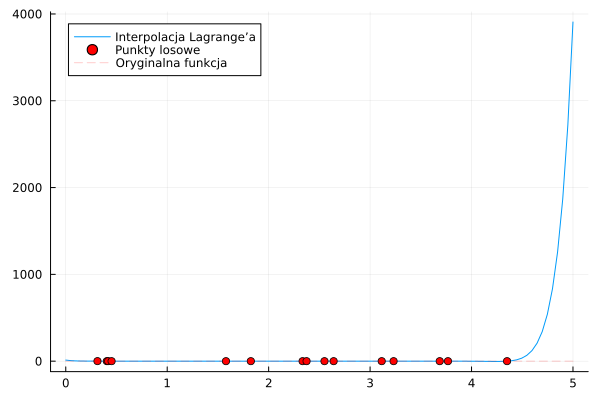

In [4]:
y_vals_lagrange = [lagrange_interpolation(x_samples, y_samples, x) for x in x_vals_universal]

plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a")
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal),label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

### Zadanie 2

##### Wielomian interpolacyjny Newtona

Postać ogólna:

$$
P_n(x) = f[x_0] + f[x_0, x_1](x - x_0) + f[x_0, x_1, x_2](x - x_0)(x - x_1) + \dots + f[x_0, x_1, \dots, x_n](x - x_0)(x - x_1) \dots (x - x_{n-1})
$$

---
Można uprościć do

$$
P_n(x) = f[x_0] + (x - x_0) [ f[x_0, x_1] + (x - x_1)[ f[x_0, x_1, x_2] + \dots + f[x_0, x_1, \dots, x_n] \dots (x - x_{n-1}) ]]
$$




![Wzór newtona cuted.png](<attachment:Wzór newtona cuted.png>)
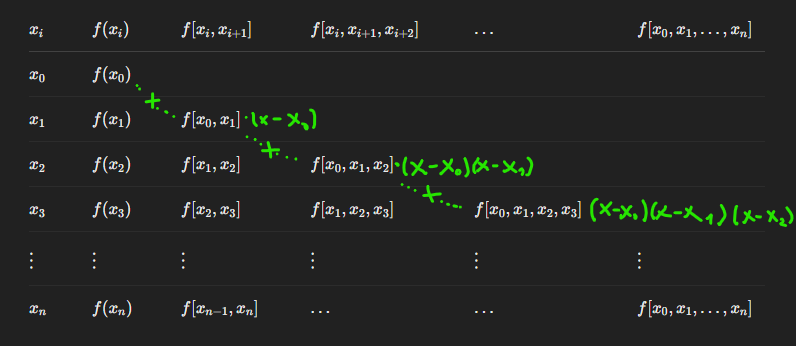

#### Newton Visualisation

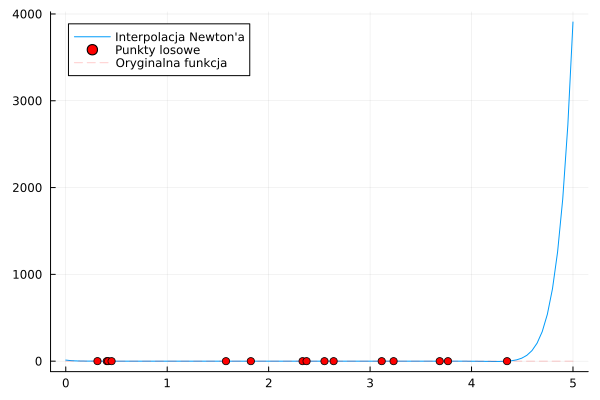

In [5]:
newt = NewtonInterpolation(x_samples, y_samples)

y_vals_newton = [NewtonHorner(newt, x, x_samples) for x in x_vals_universal]

plot(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a")
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

### Zadanie 3

#### Wielomian z pakietu Polynomials

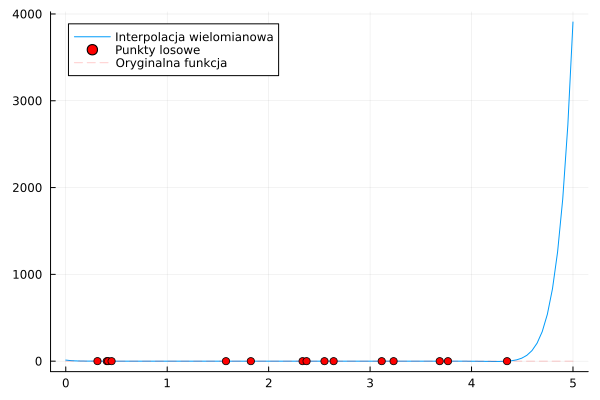

In [6]:
using Polynomials
p = Polynomials.fit(Polynomial, x_samples, y_samples)

y_vals_polynomials = [p(x) for x in x_vals_universal]

plot(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa")
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

#### Porównanie metod na jednym wykresie

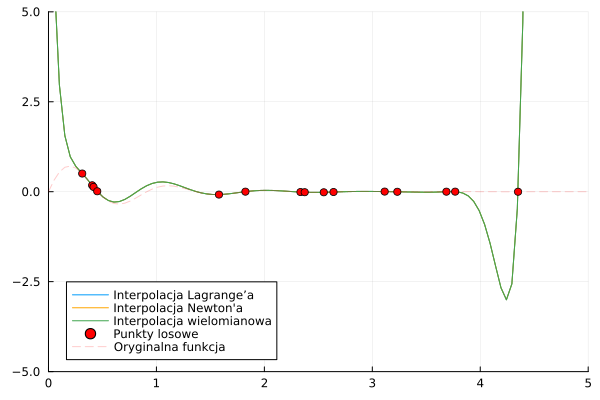

In [7]:

plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a",xlims=(0,x_max),ylims=(-5,5))
plot!(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a",color=:orange)
plot!(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa")

scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

Wygląda na to że wszystkie tworzą praktycznie takie same wykresy 👌 

Pewnie dlatego że konstruują ten sam wielomian interpolacyjny tylko na różne sposoby 🐱‍👤

-> Jeśli masz n punktów, to każda z tych metod tworzy dokładnie ten sam unikalny wielomian stopnia n−1, który przechodzi przez te punkty.

### Zadanie 4

Przygotowanie danych

In [8]:
lag_avg, lag_sd, newt_prep_avg, newt_prep_sd, newt_avg, newt_sd, 
poly_prep_avg, poly_prep_sd, poly_avg, poly_sd,x_test_vals = interpolations_time_comparision()


(Any[0.0029193899999999996, 0.00531826, 0.008106209999999999, 0.011831370000000003, 0.01554649, 0.02148293, 0.025757679999999998, 0.03365303], Any[0.0002664138445268104, 0.0003676364786639711, 0.00011286118760081635, 0.0005263563791661395, 7.80177251939866e-5, 0.0016626371669729995, 0.00025613510670911366, 0.0014867972962415259], Any[6.487000000000001e-5, 0.00016108, 0.00025095, 0.00177793, 0.00035561, 0.00040926, 0.0013879900000000002, 0.00080849], Any[1.9180258948547422e-5, 1.9997710980120808e-5, 6.58576284284685e-5, 0.004766707653681592, 1.7679646175443924e-5, 0.00015542483856978735, 0.002907919118717025, 0.0007300189852173556], Any[2.1830000000000003e-5, 3.333e-5, 4.23e-5, 4.996e-5, 5.6250000000000005e-5, 6.676999999999999e-5, 7.361000000000001e-5, 9.341e-5], Any[4.295992965026317e-7, 5.012207320355199e-7, 1.2220201853215582e-6, 2.9368161142449634e-6, 1.107800623858924e-6, 2.5077878698167455e-6, 3.717660554703726e-6, 3.662046938227004e-5], Any[2.119e-5, 4.244e-5, 6.406e-5, 8.36e-5,

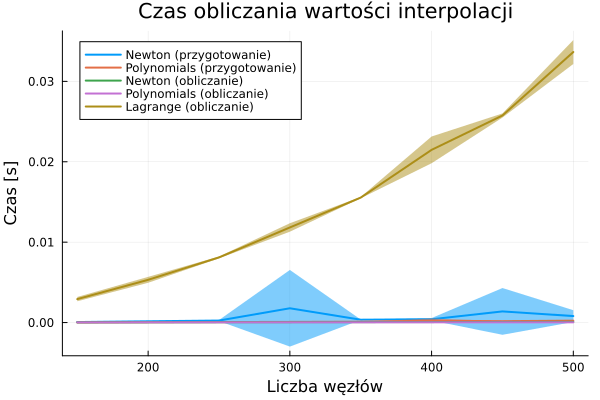

In [9]:
# Czasy przygotowania
plot(x_test_vals, newt_prep_avg;
     ribbon = newt_prep_sd,
     label = "Newton (przygotowanie)",
     xlabel = "Liczba węzłów",
     ylabel = "Czas [s]",
     title = "Czas przygotowania struktur",
     lw = 2)

plot!(x_test_vals, poly_prep_avg;
      ribbon = poly_prep_sd,
      label = "Polynomials (przygotowanie)",
      lw = 2)

# Czasy wyliczania wartości
plot!(x_test_vals, newt_avg;
     ribbon = newt_sd,
     label = "Newton (obliczanie)",
     xlabel = "Liczba węzłów",
     ylabel = "Czas [s]",
     title = "Czas obliczania wartości interpolacji",
     lw = 2)

plot!(x_test_vals, poly_avg;
      ribbon = poly_sd,
      label = "Polynomials (obliczanie)",
      lw = 2)

plot!(x_test_vals, lag_avg;
      ribbon = lag_sd,
      label = "Lagrange (obliczanie)",
      lw = 2)


#### Zadanie 5

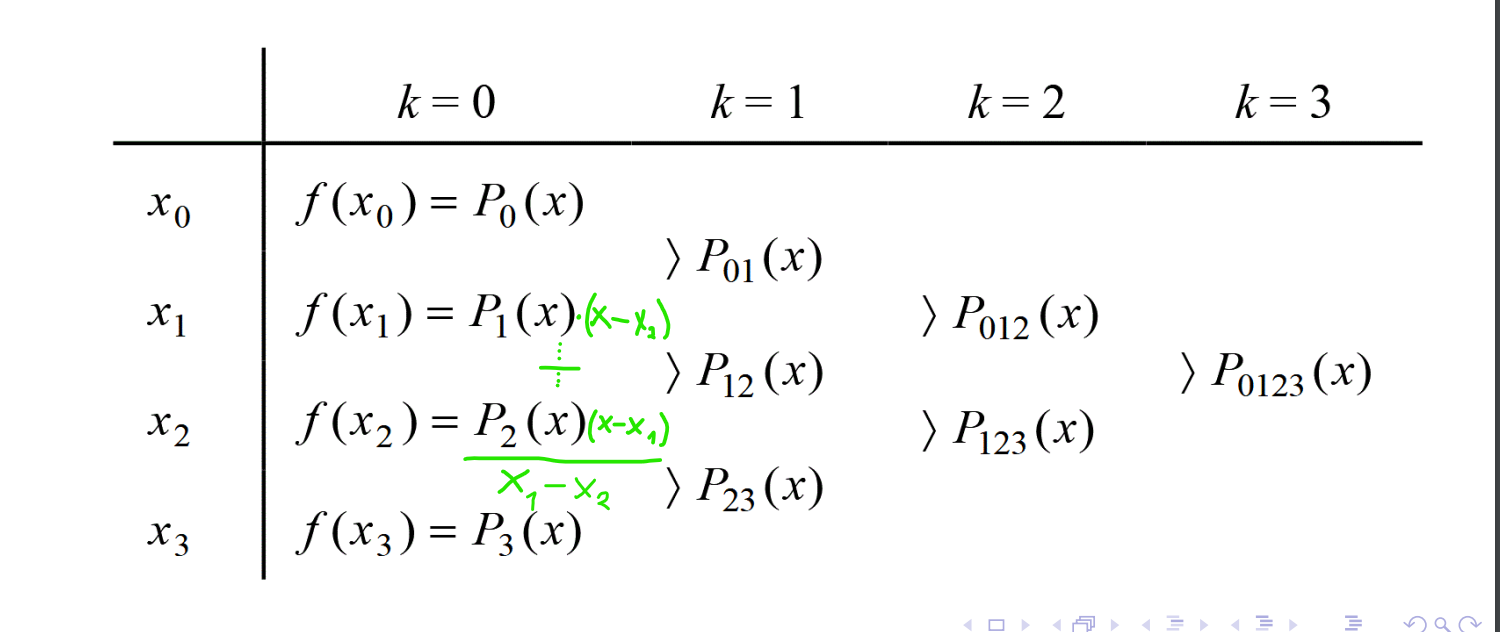

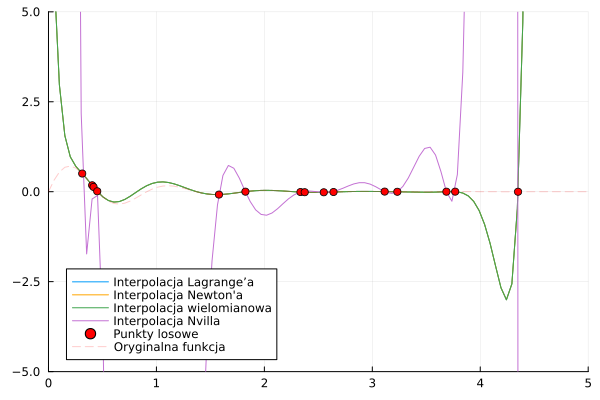

In [ ]:
y_vals_nville = [nevilleAlgo(x_samples,y_samples,x) for x in x_vals_universal]


plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a",xlims=(0,5),ylims=(-5,5))
plot!(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a",color=:orange)
plot!(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa")
plot!(x_vals_universal, y_vals_nville, label="Interpolacja Nvilla")

scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

In [12]:
# Tworzymy przykładową tablicę 2D (macierz)
matrix = [[1 ,2, 3],[ 4, 5, 6], [7, 8, 9]]

# Drukujemy tablicę 2D
println("Tablica 2D:")
for row in matrix
    println(row)
end

print(matrix[1][1])
matrix2  = zeros(3,3)
for el in matrix2
    print(el)
end 

Tablica 2D:
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
10.00.00.00.00.00.00.00.00.0

#### Zadanie 6